<h3>TODO</h3> 
Fill in any place that says <code># YOUR CODE HERE</code> (make sure to remove the line <code>raise NotImplementedError()</code>).

<h3>Suggestions</h3>

- To speed up your code, think about how certain operations can be done at the same time.
- Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).
- Double check your code does not have $\infty$-loops, these will crash the autograder.

<h3>Rules</h3>

- Blank cells in the notebook are hidden tests. **Do not delete, copy, paste, or alter these cells as this will cause the tests to fail automatically**.
- Do not create multiple python notebooks (.ipynb files).
- Do not import any new python packages (this may cause hidden tests to fail).
- Each cell must run for less than 5 minutes (there exists a solution with full marks).
- **Do not plagiarise!** We take violations of this very seriously. In previous years we have identified instances of plagiarism and reported them to the Senior Teaching & Learning Administrator.
- If you are happy with your current grade you do not need to resubmit, the most recent grade from the autograder will be your final grade.

---

In [1]:
import numpy as np
np.random.seed(0)
from numpy.matlib import repmat
import sys
import time
from l2distance import l2distance
import visclassifier
import matplotlib
import matplotlib.pyplot as plt
import traceback

import pylab
from matplotlib.animation import FuncAnimation

#new torch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#misc imports
import random

%matplotlib widget

<h3>Introduction</h3>
In this project, you will implement a linear support vector machine and one operating in kernel space. For this you will need to formulate the primal and dual optimization problems as quadratic programs. For this, we will be dipping into the shallow end with Course staffs' favorite ML framework: PyTorch!

For full documentation and details, here is their site https://pytorch.org/. PyTorch is an open source machine learning library based on the Torch library, used for applications such as computer vision and natural language processing, primarily developed by Facebook's AI Research lab. Pytorch is very neat because, as you have seen your assignments, in order to do gradient descent we've had to calculate gradient manually. No more! Pytorch performs automatic differentation, as long as we use their functions in our code.

Note: Because we are working with Pytorch functions and Modules, we will be using excusively Pytorch tensors instead of numpy arrays. This allows us to multiply/use torch parameter objects with our data directly. Pytorch tensors carry most of the same functionality as numpy arrays.

We will start with a simple example of PyTorch, where we use gradient descent to find the parameters of a simple linear regression problem.

In [2]:
def gen_regression_data(num_samples = 10000, ndims=1):
    # generate random x samples for training and test sets
    xTr = torch.rand(num_samples, ndims)
    xTe = torch.rand(int(num_samples * 0.1), ndims)
    
    # construct random w and b vectors
    gt_w = torch.randn(ndims, 1)
    gt_b = torch.randn(1)
    
    # gaussian noise for linear regression
    noise = np.random.normal(size=(num_samples, 1)) * 0.02
    test_noise = np.random.normal(size=(int(num_samples * 0.1), 1)) * 0.02
    
    # add noise on the labels for the training set
    yTr = xTr @ gt_w + gt_b + noise
    yTe = xTe @ gt_w + gt_b + test_noise
    
    return xTr, xTe, yTr, yTe, gt_w, gt_b

In [3]:
lr_xTr, lr_xTe, lr_yTr, lr_yTe, gt_w, gt_b = gen_regression_data(num_samples = 1000, ndims=1)

Now we will create our PyTorch model. PyTorch models inherit the class torch.nn.module, and you need to implement the function forward which is equivalent to a forward pass. Usually, you feed in batch of x samples as input and you get batch of outputs, but you could pass other parameters as well if needed. Every torch module will implement two functions. __init__ its constructor, and __forward__ which defines what happens when you call the module.

Note we define two fields of the <code>LinearRegressionModel</code>:
* <code>self.w</code>: The weight vector of the linear regression model. This is updated automatically by Pytorch in our training loop because we define it as a nn.Parameter (note requires_grad=True). Additionally <code>torch.randn(ndims, 1)</code> gives us an initialization for this weight vector.
* <code>self.b</code>: The bias of the linear regression model. This is also updated automatically by Pytorch in our training loop.

In [4]:
class LinearRegressionModel(nn.Module):
    def __init__(self, ndims):
        super(LinearRegressionModel, self).__init__()
        """ pytorch optimizer checks for the properties of the model, and if
            the torch.nn.Parameter requires gradient, then the model will update
            the parameters automatically.
        """
        self.w = nn.Parameter(torch.randn(ndims, 1), requires_grad=True)
        self.b = nn.Parameter(torch.randn(1), requires_grad=True)
    
    def forward(self, x):
        return x @ self.w + self.b

For this example we use our familiar mean-squared error loss.

In [5]:
def mse_loss(y_pred, y_true):
    square_diff = torch.square((y_pred-y_true))
    mean_error = 0.5 * torch.mean(square_diff)
    return mean_error

Here is a generic training loop in Pytorch, this will be very useful for you in your assignment. We have supplied comments per line to help walk you through what each different part does.

In [6]:
def train_regression_model(xTr, yTr, num_epochs, reg_param, lr=1e-2, print_freq=100):
    ndims = xTr.shape[1]
    
    model = LinearRegressionModel(ndims)  # initialize the model
    optimizer = optim.SGD(model.parameters(), lr=lr)  # create an SGD optimizer for the model parameters
    
    for epoch in range(num_epochs):
        # need to zero the gradients in the optimizer so we don't
        # use the gradients from previous iterations
        optimizer.zero_grad()  
        pred = model.forward(xTr)  # compute model predictions
        loss = mse_loss(pred, yTr) + reg_param * torch.norm(model.w)
        loss.backward()  # compute the gradient wrt loss
        optimizer.step()  # performs a step of gradient descent
        if (epoch + 1) % print_freq == 0:
            print('epoch {} loss {}'.format(epoch+1, loss.item()))
    
    return model  # return trained model

In [7]:
model = train_regression_model(lr_xTr, lr_yTr, num_epochs=2000, reg_param=0.001, lr=1e-2)
avg_test_error = mse_loss(model.forward(lr_xTe), lr_yTe)
print('avg test error', avg_test_error.item())

epoch 100 loss 0.005061221638295046
epoch 200 loss 0.0007249175685655153
epoch 300 loss 0.00038143894848558505
epoch 400 loss 0.0003457475517246039
epoch 500 loss 0.000334811039162779
epoch 600 loss 0.0003267673895703379
epoch 700 loss 0.0003198185702244381
epoch 800 loss 0.00031372128448894823
epoch 900 loss 0.00030836319923665785
epoch 1000 loss 0.0003036541001803845
epoch 1100 loss 0.0002995156567031609
epoch 1200 loss 0.00029587850320891726
epoch 1300 loss 0.00029268194147174273
epoch 1400 loss 0.00028987258899030373
epoch 1500 loss 0.0002874036242283191
epoch 1600 loss 0.0002852337315367672
epoch 1700 loss 0.00028332633605246464
epoch 1800 loss 0.0002816505771594674
epoch 1900 loss 0.000280177574155226
epoch 2000 loss 0.0002788830222064212
avg test error 0.0001655773009341101


Now, we have a trained model object that we can predict with by passing in input data via model.forward(x). Let's visualize how good of a fit our line is to the data!

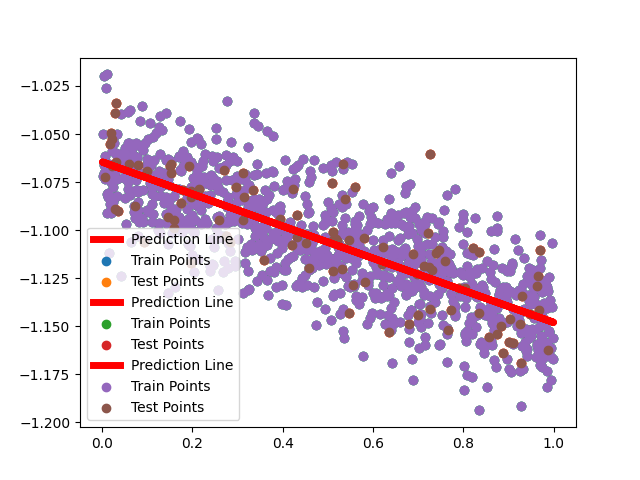

In [10]:
plt.plot(lr_xTr, model.forward(lr_xTr).detach(),linewidth=5.0, color="red", label="Prediction Line")
plt.scatter(lr_xTr, lr_yTr, label="Train Points")
plt.scatter(lr_xTe, lr_yTe, label="Test Points")
plt.legend()
plt.show()

For the following assignment there are a bunch of PyTorch specfic functions that we believe will be very helpful for you. Those are:

* <code>torch.clamp(input, min=None, max=None, *, out=None) </code>: Clamps all elements in input into the range [min, max]

* <code>torch.sum(input, *, dtype=None) </code>: Returns the sum of all elements in the input tensor.

* <code>torch.mean(input, *, dtype=None)</code>: Returns the mean value of all elements in the input tensor.

* <code>torch.pow(input, exponent, *, out=None)</code>: Takes the power of each element in input with exponent and returns a tensor with the result.

* <code>torch.exp(input, *, out=None)</code>: Returns a new tensor with the exponential of the elements of the input tensor.

<h3> Linear classification</h3>

<p> The first part of the assignment is to implement a linear support vector machine. In order to do this, we are going to generate random data to classify:
</p>

In [11]:
def genrandomdata(n=100,b=0.):
    # generate random data and linearly separable labels
    xTr = np.random.randn(n, 2)
    # defining random hyperplane
    w0 = np.random.rand(2, 1)
    # assigning labels +1, -1 labels depending on what side of the plane they lie on
    yTr = np.sign(np.dot(xTr, w0)+b).flatten()
    return torch.from_numpy(xTr).float(), torch.from_numpy(yTr).float()

<p>Remember the SVM primal formulation
$$\begin{aligned}
             &\min_{\mathbf{w},b,\xi} \|\mathbf{w}\|^2_2+C \sum_{i=1}^n \xi_i\\
       & \text{such that }  \ \forall i:\\
             & y_i(\mathbf{w}^\top \mathbf{x}_i+b)\geq 1-\xi_i\\
             & \xi_i\geq 0.\\
\end{aligned}
$$
You will need to implement  the function <code>primalSVM</code>, which takes in training data <code>xTr</code> ($n\times d$) and labels <code>yTr</code> ($n$) with <code>yTr[i]</code>$\in \{-1,1\}$. Note that we aren't doing linear programming, this is gradient descent optimization so the constraints are something we do not worry about.</p>

To warm up, implement <code>hinge_loss</code>, which calculates the loss described in $\sum_{i=1}^n \xi_i$. Working with torch tensors is a lot like working with numpy tensors, think about the best way to do tensor on tensor operations. <b>This method requires no loops</b>.

Hint: <code>torch.clamp</code> might be useful here

In [12]:
def hinge_loss(y_pred, y_true):
    # YOUR CODE HERE
    margin = 1 - y_pred*y_true
    loss = torch.clamp(margin, min=0).mean()
    return loss

Next, implement <code>LinearSVM</code>. This is a module (similar to the one in the example above) which initializes a linear classifer in dimension <code>dim</code>. In this module, you will need to initialize the necessary parameters for a linear model and define the forward pass for an input x. Hint: It <b>should</b> look very similar to what you have done before.

In [13]:
class LinearClassifier(nn.Module):
    """Support Vector Machine"""

    def __init__(self, dim):
        # YOUR CODE HERE
        super(LinearClassifier, self).__init__()
        self.w = nn.Parameter(torch.randn(dim, 1), requires_grad=True)
        self.b = nn.Parameter(torch.randn(1), requires_grad=True)

    def forward(self, x):
        # YOUR CODE HERE
        return x @ self.w + self.b

Finally, implement <code>primalSVM</code>. This is a method which takes in a set of training data <code>xTr</code> and labels <code>yTr</code>, a number of epochs <code>num_epochs</code> to train for, and our SVM <code>C</code> hyper-parameter. You should return a lambda function (https://www.w3schools.com/python/python_lambda.asp) <code>svmclassify</code> that produces a forward pass of your trained model.

In [97]:
def primalSVM(xTr, yTr, num_epochs=1000, C=1):
    # Convert to PyTorch tensors
    # xTr = xTr.float()  # Ensure xTr is of type float
    # yTr = yTr.float().view(-1, 1)  # Ensure yTr is a column vector of type float
    # xTr = xTr.clone().detach().requires_grad_(True)
    # yTr = yTr.clone().detach().requires_grad_(True)
    
    # # Initialize the Linear Classifier
    # model = LinearClassifier(xTr.size(1))
    # optimizer = optim.SGD(model.parameters(), lr=1e-2)

    # # Training loop
    # for epoch in range(num_epochs):
    #     optimizer.zero_grad()  # Zero the gradients
    #     output = model.forward(xTr).squeeze()  # Forward pass and squeeze output
    #     loss = C * hinge_loss(output, yTr.squeeze())  # Apply hinge loss, make sure yTr matches output shape
    #     regularization_loss = 0.5 * torch.norm(model.w) ** 2  # L2 regularization
    #     total_loss = loss + regularization_loss
    #     total_loss.backward()  # Backward pass
    #     optimizer.step()  # Update the parameters

    #     if epoch % 100 == 0:  # Monitor the progress
    #         print(f'Epoch {epoch}, Loss: {total_loss.item()}')

    # # After training, return a lambda function for classification
    # # Squeeze output to ensure it returns a 1D tensor for classification predictions
    # svmclassify = lambda x: model(x.clone().detach().requires_grad_(False)).squeeze()

    # model initialisation
    model = LinearClassifier(xTr.size(1))

    
    optimizer = optim.SGD(model.parameters(), lr=1e-2)  # create an SGD optimizer for the model parameters
    # model training
    for epoch in range(num_epochs): 
        optimizer.zero_grad()
        y_pred = model.forward(xTr).squeeze()
        weight = model.w.squeeze()
        loss = C * hinge_loss(y_pred, yTr) + weight.t() @ weight
        loss.backward()  
        optimizer.step()  

    svmclassify = lambda x: model.forward(x).flatten()
    
    return svmclassify


We can test your SVM primal solver with the following randomly generated data set. We label it in a way that it is guaranteed to be linearly separable. If your code works correctly the hyper-plane should separate all the $x$'s into the red half and all the $o$'s into the blue half. With sufficiently large values of $C$ (e.g. $C>10$) you should obtain $0\%$ training error. 

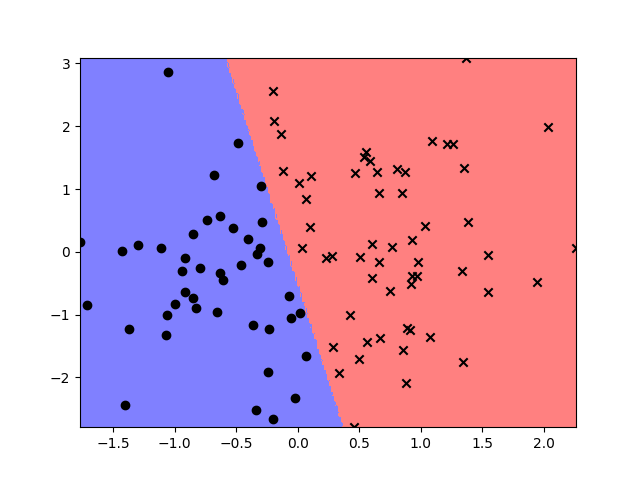

Training error: 0.0%


In [100]:
xTr,yTr = genrandomdata()
fun = primalSVM(xTr,yTr,C=10)
visclassifier.visclassifier(fun,xTr,yTr)
err=torch.mean((torch.sign(fun(xTr))!=yTr).float())
print("Training error: %2.1f%%" % (err*100))

In [ ]:
# Hidden Test 1: testCase_Primal
# ------------------------------
# Given a fixed training set, this tests if the signs of predictions are correct

In [ ]:
# Hidden Test 2: testCase_Primal
# ------------------------------
# Given a fixed training set, this tests if points farther from the decision boundary have larger predictions.

<h3>Spiral data set</h3>

<p>The linear classifier works great in simple linear cases. But what if the data is more complicated? We provide you with a "spiral" data set. You can load it and visualize it with the following two code snippets:
<pre>

In [16]:
def spiraldata(N=300):
    r = np.linspace(1,2*np.pi,N)
    xTr1 = np.array([np.sin(2.*r)*r, np.cos(2*r)*r]).T
    xTr2 = np.array([np.sin(2.*r+np.pi)*r, np.cos(2*r+np.pi)*r]).T
    xTr = np.concatenate([xTr1, xTr2], axis=0)
    yTr = np.concatenate([np.ones(N), -1 * np.ones(N)])
    xTr = xTr + np.random.randn(xTr.shape[0], xTr.shape[1])*0.2
    
    xTe = xTr[::2,:]
    yTe = yTr[::2]
    xTr = xTr[1::2,:]
    yTr = yTr[1::2]
    
    xTr = torch.tensor(xTr).float()
    yTr = torch.tensor(yTr).float()
    xTe = torch.tensor(xTe).float()
    yTe = torch.tensor(yTe).float()
    
    vals, indices = torch.max(xTr, dim=0, keepdim=True)
    xTr /= (vals * 2.0)
    vals, indices = torch.max(xTe, dim=0, keepdim=True)
    xTe /= (vals * 2.0)
    
    return xTr,yTr,xTe,yTe

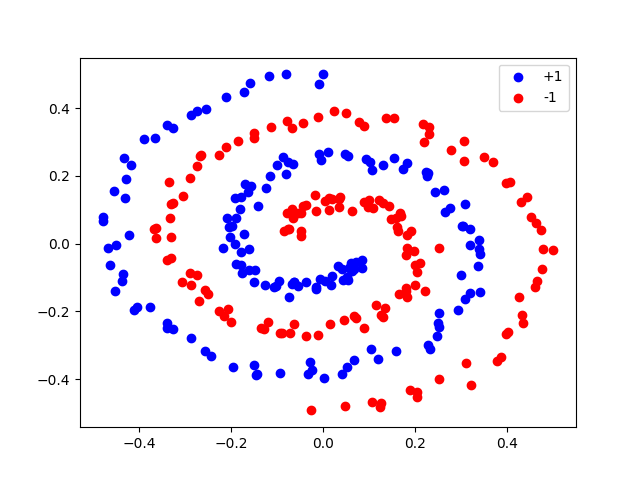

In [17]:
xTr,yTr,xTe,yTe=spiraldata()
plt.figure()
plt.scatter(xTr[yTr == 1, 0], xTr[yTr == 1, 1], c='b')
plt.scatter(xTr[yTr != 1, 0], xTr[yTr != 1, 1], c='r')
plt.legend(["+1","-1"])
plt.show()

<p>If you apply your previously functioning linear classifier on this data set you will see that you get terrible results. Your training error will increase drastically. </p>

Epoch 0, Loss: 10.85890007019043
Epoch 100, Loss: 9.923319816589355
Epoch 200, Loss: 9.850605964660645
Epoch 300, Loss: 9.840863227844238
Epoch 400, Loss: 9.839558601379395
Epoch 500, Loss: 9.839383125305176
Epoch 600, Loss: 9.839361190795898
Epoch 700, Loss: 9.839356422424316
Epoch 800, Loss: 9.839356422424316
Epoch 900, Loss: 9.83935546875


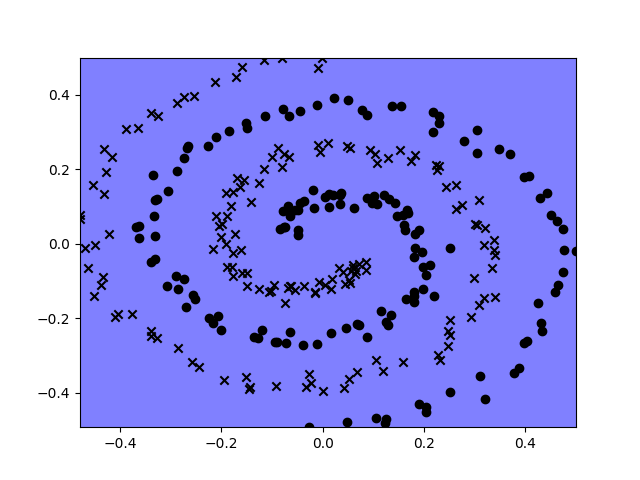

Training error: 50.0%


In [18]:
fun=primalSVM(xTr,yTr,C=10)
visclassifier.visclassifier(fun,xTr,yTr)
err=torch.mean(((torch.sign(fun(xTr)))!=yTr).float())
print("Training error: %2.1f%%" % (err*100))

<h3>Implementing a kernelized SVM</h3>

<p> For a data set as complex as the spiral data set, you will need a more complex classifier. 
First implement the kernel function
<pre>	computeK(kernel_type,X,Z,kpar)</pre>
It takes as input a kernel type <code>kernel_type</code> and two data sets $\mathbf{X} \in \mathcal{R}^{n\times d}$ and $\mathbf{Z} \in \mathcal{R}^{m\times d}$ and outputs a kernel matrix $\mathbf{K}\in{\mathcal{R}^{n\times m}}$. The last input, <code>kpar</code> specifies the kernel parameter (e.g. the inverse kernel width $\gamma$ in the RBF case or the degree $p$ in the polynomial case.)
	<ol>
	<li>For the linear kernel (<code>kernel_type='linear'</code>) svm, use $k(\mathbf{x},\mathbf{z})=x^Tz$ </li> 
	<li>For the radial basis function kernel (<code>kernel_type='rbf'</code>) svm use $k(\mathbf{x},\mathbf{z})=\exp(-\gamma ||x-z||^2)$ (gamma is a hyperparameter, passed as the value of kpar)</li>
	<li>For the polynomial kernel (<code>kernel_type='poly'</code>) use  $k(\mathbf{x},\mathbf{z})=(x^Tz + 1)^d$ (d is the degree of the polymial, passed as the value of kpar)</li>
</ol>

<p>You can use the function <b><code>l2distance</code></b> as a helperfunction, which is located in defined in one of your starter files l2distance.py.</p>

In [19]:
def computeK(kernel_type, X, Z, kpar=0):
    """
    function K = computeK(kernel_type, X, Z)
    computes a matrix K such that Kij=k(x,z);
    for three different function linear, rbf or polynomial.
    
    Input:
    kernel_type: either 'linear','polynomial','rbf'
    X: n input vectors of dimension d (nxd);
    Z: m input vectors of dimension d (mxd);
    kpar: kernel parameter (inverse kernel width gamma in case of RBF, degree in case of polynomial)
    
    OUTPUT:
    K : nxm kernel Torch float tensor
    """
    assert kernel_type in ["linear","polynomial","poly","rbf"], "Kernel type %s not known." % kernel_type
    assert X.shape[1] == Z.shape[1], "Input dimensions do not match"
    
    # YOUR CODE HERE
    if kernel_type == "linear":
        K = torch.mm(X, Z.t())
    elif kernel_type in ["polynomial", "poly"]:
        K = torch.pow(torch.mm(X, Z.t()) + 1, kpar)
    elif kernel_type == "rbf":
        X_square = torch.sum(X ** 2, dim=1).view(-1, 1)
        Z_square = torch.sum(Z ** 2, dim=1).view(1, -1)
        distance_matrix = X_square - 2 * torch.mm(X, Z.t()) + Z_square
        K = torch.exp(-kpar * distance_matrix)
        
    return K

In [ ]:
# Hidden Test 3: testCase_computeK_linear
# ---------------------------------------
# This tests whether the linear kernel is computed properly on an example dataset.

In [ ]:
# Hidden Test 4: testCase_computeK_polynomial
# -------------------------------------------
# This tests whether the polynomial kernel is computed properly on an example dataset.

In [ ]:
# Hidden Test 5: testCase_computeK_rbf
# ------------------------------------
# This tests whether the rbf kernel is computed properly on an example dataset.

<h3>Additional Testing</h3>
<p>The following code snippet plots an image of the kernel matrix for the data points in the spiral set. Use it to test your <b><code>computeK</code></b> function:</p>

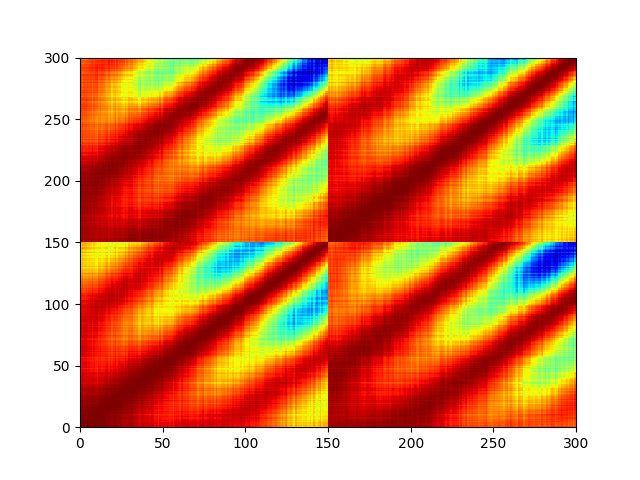

In [20]:
xTr,yTr,xTe,yTe=spiraldata()
K=computeK("rbf",xTr,xTr,kpar=0.05)
# plot an image of the kernel matrix
plt.figure()
plt.pcolormesh(K, cmap='jet')
plt.show()

Remember that the SVM optimization has the following dual formulation: (1)
$$
\begin{aligned}
             &\min_{\alpha_1,\cdots,\alpha_n}\frac{1}{2} \sum_{i,j}\alpha_i \alpha_j y_i y_j \mathbf{K}_{ij} - \sum_{i=1}^{n}\alpha_i  \\
       \text{s.t.}  &\quad 0 \leq \alpha_i \leq C\\
             &\quad \sum_{i=1}^{n} \alpha_i y_i = 0.
\end{aligned}
$$
This is equivalent to solving for the SVM primal (2)
$$ L(\mathbf{w},b) = C\sum_{i=1}^n \max(1-y_i(\mathbf{w}^\top\phi(\mathbf{x}_i)+b),0) + ||w||_2^2$$
where $\mathbf{w}=\sum_{i=1}^n y_i \alpha_i \phi(\mathbf{x}_i)$ and $\mathbf{K}_{ij}=k(\mathbf{x}_i,\mathbf{x}_j)=\phi(\mathbf{x}_i)^\top\phi(\mathbf{x}_j)$, for some mapping $\phi(\cdot)$. However, after a change of variable, with $\beta_i = \alpha_iy_i$ and $\beta \in R^n$, (2) can be rewritten as follows (see https://arxiv.org/pdf/1404.1066.pdf for details):
$$ min_{\beta, b} \frac{1}{2}\beta^\top K\beta + \frac{C}{2}\sum_{i=1}^n {[\max(1-y_i(\beta^\top k_i+b),0)]}^2$$
where $k_i$ is the kernel matrix row corresponding to the ith training example. Notice that there are two relaxations: 1. the $\beta_i$ are unconstrained, in contrast to $\alpha_i$ in (1), which must satisfy $0 \leq \alpha_i \leq C$; and 2. the squared hinge loss is used in place of the more common absolute hinge loss.


<p>
    Implement the module 
    <pre>
    KernelizedSVM(dim, kernel_type, kpar=0)
    </pre>
    This is a kernelized version of the SVM as defined above, which must maintain some kind of internal parameters for beta and b (hint: think what <code>dim</code> should be as a function of our training data) should be used for. Further, you are given <code>kernel_type</code> and <code>kpar</code>, which you should use in the creation of kernels by means of the method you wrote above <code>computeK</code>. For the forward pass of the kernelized SVM, recall that it is defined as $h(x) = w^\top \phi(x) + b$, where $w = \sum_{i=1}^n \beta_i\phi(x_i)$. The output of your forward pass should be the classification itself of input data x.
</p>

In [21]:
class KernelizedSVM(nn.Module):
    def __init__(self, dim, kernel_type, kpar=0):
        # YOUR CODE HERE
        super(KernelizedSVM, self).__init__()
        self.beta = nn.Parameter(torch.randn(dim, 1)*0.01, requires_grad=True)
        self.b = nn.Parameter(torch.randn(1)*0.01, requires_grad=True)
        self.kernel_type = kernel_type
        self.kpar = kpar
    
    def forward(self, xTr, x):
        # YOUR CODE HERE
        # x: the new input
        K = computeK(self.kernel_type, xTr, x, self.kpar)
        decision_values = K.t() @ self.beta + self.b
        
        # Return the sign of the decision function
        return torch.sign(decision_values)

<p>
    Implement the function 
    <pre>
    kernelsvm_loss(kernelizedSVM, kernel_mat, yTr, C)
    </pre>
    It should implement the loss function described above for the equivalent primal formulation of the dual:
    $$ min_{\beta, b} \frac{1}{2}\beta^\top K\beta + \frac{C}{2}\sum_{i=1}^n {[\max(1-y_i(\beta^\top k_i+b),0)]}^2$$
  You are given a KernalizedSVM module (<code>kernelizedSVM</code>) which you defined above, the kernel (<code>kernel_mat</code>), the training labels (<code>yTr</code>), and the regularizatin paramater (<code>C</code>). 
 
Note that this function <b>requires no loops</b>, and that you may find two functions especially helpful 
* <code>F.relu(x)</code> computes the <code>max(x,0)</code> in a way that allows for our optimizers to work (F is torch.nn.Functional, a library imported above) 
* <code>torch.square(x)</code> Returns a new tensor with the square of the elements of input.
</p>

In [22]:
def kernelsvm_loss(kernelizedSVM, kernel_mat, yTr, C):
    # YOUR CODE HERE
    beta = kernelizedSVM.beta
    b = kernelizedSVM.b

    # Calculate the regularization term (1/2 * βᵀKβ)
    reg_term = 0.5 * torch.mm(torch.mm(beta.t(), kernel_mat), beta)

    # Compute the decision values (Kᵢ * β + b)
    decision_values = torch.mm(kernel_mat, beta) + b

    # Calculate the hinge loss term (C/2 * ∑[max(1 - yᵢ(Kᵢᵀβ + b), 0)]²)
    hinge_losses = F.relu(1 - yTr * decision_values)
    hinge_loss_term = C / 2 * torch.sum(torch.square(hinge_losses))

    # Sum the regularization term and the hinge loss term to get the cumulative loss
    cumulative_loss = reg_term + hinge_loss_term

    return cumulative_loss

<p>
    Implement the function 
    <pre>
    dualSVM(xTr, yTr, kernel_type, num_epochs, C, kpar, lr)
    </pre>
    It should use your functions <code><b>kernelsvm_loss</b></code>, <code><b>computeK</b></code>, and <code><b>KernelizedSVM</b></code> to solve the SVM dual problem of an SVM specified by a training data set (<code><b>xTr,yTr</b></code>), a regularization parameter (<code>C</code>), a kernel type (<code>ktype</code>) and kernel parameter (<code>lmbda</code>), to be used as kpar in Kernel construction. This will once again be a training loop similar to the primalSVM above. You should return a lambda function <code>svmclassify</code> that produces a forward pass of your trained model.
</p>

In [23]:
def dualSVM(xTr, yTr, kernel_type, num_epochs=100, C=1, lmbda=0, lr=1e-2):
    # YOUR CODE HERE
    # Convert inputs to PyTorch tensors if they aren't already
    #xTr = torch.tensor(xTr, dtype=torch.float32)
    xTr = xTr.float()  # Ensure xTr is of type float
    yTr = yTr.float().view(-1, 1)  # Ensure yTr is a column vector of type float
    # xTr = xTr.clone().detach().requires_grad_(True)
    # #yTr = torch.tensor(yTr, dtype=torch.float32).view(-1, 1)
    # yTr = yTr.clone().detach().requires_grad_(True)

    
    # Initialize the SVM model
    model = KernelizedSVM(xTr.size(0), kernel_type, lmbda)
    
    # Define the optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    # Training loop
    for epoch in range(num_epochs):
        # Zero the gradients
        optimizer.zero_grad()
        
        # Compute the kernel matrix for the current model parameters
        kernel_mat = computeK(kernel_type, xTr, xTr, lmbda)
        
        # Compute the loss
        loss = kernelsvm_loss(model, kernel_mat, yTr, C)
        
        # Backpropagate the loss
        loss.backward()
        
        # Update the model parameters
        optimizer.step()
        
        # Print out the loss every so often (or use any other form of logging/monitoring)
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
            
    support_vectors = xTr
    alphas = model.beta.detach()

    # svmclassify = lambda x: model(xTr, torch.tensor(x, dtype=torch.float32)).detach()
    svmclassify = lambda x: torch.sign(model(xTr, x).flatten())
    
    return svmclassify

<h3>Testing</h3>
<p>Now we try the SVM with RBF kernel on the spiral data. If you implemented it correctly, train and test error should be close to zero.</p>

Epoch 0, Loss: 149.94036865234375
Epoch 10, Loss: 84.85429382324219
Epoch 20, Loss: 60.53369903564453
Epoch 30, Loss: 47.58582305908203
Epoch 40, Loss: 40.14687728881836
Epoch 50, Loss: 35.703670501708984
Epoch 60, Loss: 32.97121810913086
Epoch 70, Loss: 31.246662139892578
Epoch 80, Loss: 30.13247299194336


Epoch 90, Loss: 29.396589279174805
Epoch 100, Loss: 28.899188995361328
Epoch 110, Loss: 28.554771423339844
Epoch 120, Loss: 28.310823440551758
Epoch 130, Loss: 28.133934020996094
Epoch 140, Loss: 28.002492904663086
Epoch 150, Loss: 27.902339935302734
Epoch 160, Loss: 27.824066162109375
Epoch 170, Loss: 27.761356353759766
Epoch 180, Loss: 27.70992660522461
Epoch 190, Loss: 27.66677474975586
Epoch 200, Loss: 27.629833221435547
Epoch 210, Loss: 27.597644805908203
Epoch 220, Loss: 27.569137573242188
Epoch 230, Loss: 27.543590545654297
Epoch 240, Loss: 27.52041244506836
Epoch 250, Loss: 27.499187469482422
Epoch 260, Loss: 27.479595184326172
Epoch 270, Loss: 27.46141242980957
Epoch 280, Loss: 27.444425582885742
Epoch 290, Loss: 27.428495407104492
Epoch 300, Loss: 27.41347312927246
Epoch 310, Loss: 27.399290084838867
Epoch 320, Loss: 27.385845184326172
Epoch 330, Loss: 27.37305450439453
Epoch 340, Loss: 27.360885620117188
Epoch 350, Loss: 27.349266052246094
Epoch 360, Loss: 27.338146209716797

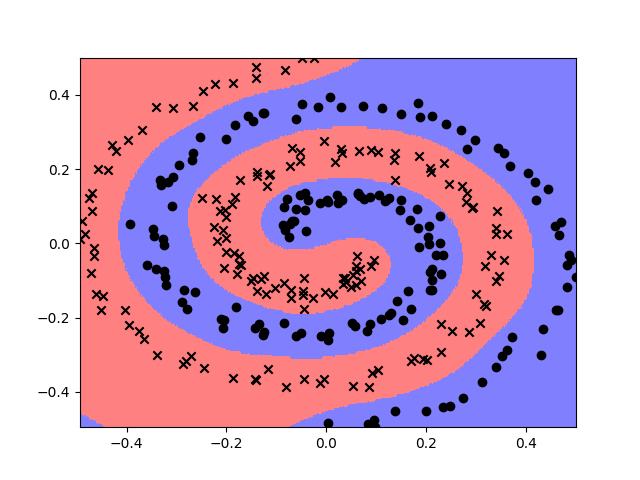

Training error: 0.0000
Testing error: 0.0000


In [101]:
xTr,yTr,xTe,yTe=spiraldata()

# poly kernel parameters that don't blow up vvv
# ktype="poly"
# svmclassify=dualSVM(xTr, yTr, kernel_type=ktype, num_epochs=10, C=0.1, lmbda=0.05, lr=1e-4)
# visclassifier.visclassifier(svmclassify,xTr,yTr)

# linear kernel parameters that also don't blow up vvv
# ktype="linear"
# svmclassify=dualSVM(xTr, yTr, kernel_type=ktype, num_epochs=10, C=0.1, lmbda=0.05, lr=1e-4)
# visclassifier.visclassifier(svmclassify,xTr,yTr)

# rbf kernel with parameters that achieve perfect accuracy vvv 
ktype="rbf"
svmclassify=dualSVM(xTr, yTr, kernel_type=ktype, num_epochs=1000, C=1, lmbda=100, lr=1e-3)
visclassifier.visclassifier(svmclassify,xTr,yTr)

# compute training and testing error
predsTr=svmclassify(xTr)
trainingerr=torch.mean((torch.sign(predsTr)!=yTr).float())
print("Training error: %2.4f" % trainingerr)

predsTe=svmclassify(xTe)
testingerr=torch.mean((torch.sign(predsTe)!=yTe).float())
print("Testing error: %2.4f" % testingerr)

<h3>Testing Hint</h3> Create a dataset where you know what some of the optimal values of $\alpha$ will be, and test to make sure that the solution gets those values of $\alpha$ correct (recall from the lecture that the $\alpha$ values associated with certain data points are guaranteed to have a specific optimal value).

In [ ]:
# Hidden Test 6: testCase_dualSVM_easy_dataset
# --------------------------------------------
# This tests whether the function from dualSVM correctly classifies an example dataset.

In [ ]:
# Hidden Test 7: testCase_dualSVM_hard_dataset
# --------------------------------------------
# This tests whether the function from dualSVM correctly classifies a hard example dataset.

In [ ]:
# Hidden Test 8: testCase_dualSVM_hard_dataset2
# ---------------------------------------------
# This tests whether the function from dualSVM correctly classifies an even harder example dataset.

SVMs are pretty sensitive to hyper-parameters. We ask you to implement a cross-validation function. <code>cross_validation</code> which takes training data <code>xTr</code>, training labels <code>yTr</code>, validation data <code>xValid</code>, validation labels <code>yValid</code>, kernel type <code>ktype</code>, list of possible C values <code>CList</code>, list of lambda values for kernel generation <code>lmbdaList</code>, and list of learning rates <code>lr_list</code>.

Note that we don't have <code>epochs</code> as a hyper-parameter to tune even, though the number of epochs we train on can vastly change the performance of our model. Generally we train with gradient descent <b>until convergence</b> (when train/validation loss stop decreasing); therefore, something you can do to get a good idea of what amount of epochs you need is plot [epoch number x (training,validation)] loss! <b>This convergence part will not be tested</b>, but is something that might help. 

<h3>Testing</h3>

In [70]:
def cross_validation(xTr,yTr,xValid,yValid,ktype,CList,lmbdaList,lr_List):
    """
    function bestC,bestLmbda,ErrorMatrix = cross_validation(xTr,yTr,xValid,yValid,ktype,CList,lmbdaList);
    Use the parameter search to find the optimal parameter,
    Individual models are trained on (xTr,yTr) while validated on (xValid,yValid)
    
    Input:
        xTr      | training data (nxd)
        yTr      | training labels (nx1)
        xValid   | training data (mxd)
        yValid   | training labels (mx1)
        ktype    | the type of kernelization: 'rbf','polynomial','linear'
        CList    | The list of values to try for the SVM regularization parameter C (ax1)
        lmbdaList| The list of values to try for the kernel parameter lmbda- degree for poly, inverse width for rbf (bx1)
        lr_list  | The list of values to try for the learning rate of our optimizer
    
    Output:
        bestC      | the best C parameter
        bestLmbda  | the best Lmbda parameter
        bestLr     | the best Lr parameter
        ErrorMatrix| the test error rate for each given (C, Lmbda Lr) tuple when trained on (xTr,yTr) and tested on (xValid,yValid)
    """
    # YOUR CODE HERE
    best_val_error = float('inf')
    bestC = None
    bestLmbda = None
    bestLr = None
    ErrorMatrix = torch.zeros(len(CList), len(lmbdaList), len(lr_List))

    # xTr = torch.tensor(xTr, dtype=torch.float32)
    xTr = xTr.clone().detach().requires_grad_(True)
    # yTr = torch.tensor(yTr, dtype=torch.float32).view(-1, 1)
    yTr = yTr.clone().detach().requires_grad_(True)
    # xValid = torch.tensor(xValid, dtype=torch.float32)
    xValid = xValid.clone().detach().requires_grad_(True)
    # yValid = torch.tensor(yValid, dtype=torch.float32).view(-1, 1)
    yValid = yValid.clone().detach().requires_grad_(True)

    max_epochs = 100

    for i, C in enumerate(CList):
        for j, lmbda in enumerate(lmbdaList):
            for k, lr in enumerate(lr_List):
                model = KernelizedSVM(xTr.size(0), ktype, lmbda)
                optimizer = optim.SGD(model.parameters(), lr=lr)

                for epoch in range(max_epochs):
                    model.train()
                    optimizer.zero_grad()
                    kernel_mat = computeK(ktype, xTr, xTr, lmbda)
                    loss = kernelsvm_loss(model, kernel_mat, yTr, C)
                    loss.backward()
                    
                    # Optional: Gradient clipping
                    # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                    optimizer.step()

                    model.eval()
                    with torch.no_grad():
                        kernel_mat_val = computeK(ktype, xTr, xValid, lmbda)
                        val_loss = kernelsvm_loss(model, kernel_mat_val, yValid, C)
                        val_error = 1.0 - torch.mean((torch.sign(model(xTr, xValid).flatten()) == yValid).float()).item()

                    ErrorMatrix[i, j, k] = val_error

                    if val_error < best_val_error:
                        best_val_error = val_error
                        bestC = C
                        bestLmbda = lmbda
                        bestLr = lr
                        
    return bestC,bestLmbda,bestLr,ErrorMatrix

In [ ]:
# Hidden Test 9: testCase_cv
# ---------------------------
# This tests whether the best hyperparameters found by cross validation are correct for an example dataset.

<h3>Competition</h3>


We ask you to implement function autosvm, which given xTr and yTr, splits them into training data and validation data, and then uses a hyperparameter search to find the optimal hyper parameters. 

Function autosvm should return a function which will act as a classifier on xTe.

You have a 5 minute time limit on multiple datasets, each dataset having different optimal hyperparameters, so you should strive for a good method of finding hyperparameters (within the time limit) instead of just trying to find a static set of good hyperparameters. 

You will get full credit for the competition if you can beat the base benchmark of <b>46% error</b> (you will get partial credit if you beat <b>50% error</b>).

In [134]:
def autosvm(xTr,yTr):
    """
    svmclassify = autosvm(xTr,yTr), where yTe = svmclassify(xTe)
    """
    
    start_time = time.time()
    indices = torch.randperm(len(yTr)).tolist()
    split = int(0.8 * len(yTr))
    xTrain,yTrain = xTr[indices[:split]],yTr[indices[:split]]
    xValid,yValid = xTr[indices[split:]],yTr[indices[split:]]

    kernel_types = ["rbf","polynomial","linear"]
    lrList=[1e-3, 1e-2] 
    
    n_runs = {'linear': 2, 'polynomial': 6, 'rbf': 12}
    min_err = 1
    
    min_err = 1
    for kernel in kernel_types:
        if kernel == "rbf":
            CList = [0.01,0.1,1,10,20,50,100]
            lmbdalist = [1e-3,1e-2,1e-1,1,10,100,500]

        elif kernel == "polynomial":
            CList = [1,10]
            lmbdalist = [2,3,4,5,6]
        else:
            CList = [1,10]
            lmbdalist = [0]
            
        for i in range(n_runs[kernel]):
            C = random.choice(CList)
            Lmbda = random.choice(lmbdalist)
            Lr = random.choice(lrList)
            k_svm = dualSVM(xTrain, yTrain, kernel, num_epochs=500, C=C, lmbda=Lmbda, lr=Lr)
            y_pred = k_svm(xValid)
            val_err=torch.mean((torch.sign(y_pred)!=yValid).float())
            print(f'Kernel: {kernel}, Iteration:{i}, C: {C}, Lmbda: {Lmbda}, Lr: {Lr}, Error: {val_err}')
            if val_err < min_err:
                min_err = val_err
                bestKernel,bestC, bestLmbda, bestLr = kernel, C, Lmbda, Lr 
                print(f'Best params so far: Kernel: {bestKernel}, C: {bestC}, Lmbda: {bestLmbda}, Lr: {bestLr}, Error: {min_err}')
        final_model = dualSVM(xTr, yTr, kernel_type=bestKernel, num_epochs=1000, C = bestC, lmbda=bestLmbda, lr=bestLr) 
        svmclassify = lambda x: final_model(x).flatten()
    end_time = time.time()
    print(f'Total time used: {end_time - start_time}s')
    return svmclassify

In [62]:
xTr.shape

torch.Size([300, 2])

In [127]:
(np.linspace(0.01,50,8))

array([1.00000000e-02, 7.15142857e+00, 1.42928571e+01, 2.14342857e+01,
       2.85757143e+01, 3.57171429e+01, 4.28585714e+01, 5.00000000e+01])

In [122]:
(2.0**np.linspace(-1,5,8))

array([ 0.5       ,  0.90572366,  1.64067071,  2.97198858,  5.38360077,
        9.75210923, 17.66543222, 32.        ])

Epoch 0, Loss: 124.79564666748047
Epoch 10, Loss: 7.96930544922471e+23
Epoch 20, Loss: inf
Epoch 30, Loss: inf
Epoch 40, Loss: nan
Epoch 50, Loss: nan
Epoch 60, Loss: nan
Epoch 70, Loss: nan
Epoch 80, Loss: nan
Epoch 90, Loss: nan
Epoch 100, Loss: nan
Epoch 110, Loss: nan
Epoch 120, Loss: nan
Epoch 130, Loss: nan
Epoch 140, Loss: nan
Epoch 150, Loss: nan
Epoch 160, Loss: nan
Epoch 170, Loss: nan
Epoch 180, Loss: nan
Epoch 190, Loss: nan
Epoch 200, Loss: nan
Epoch 210, Loss: nan
Epoch 220, Loss: nan
Epoch 230, Loss: nan
Epoch 240, Loss: nan
Epoch 250, Loss: nan
Epoch 260, Loss: nan
Epoch 270, Loss: nan
Epoch 280, Loss: nan
Epoch 290, Loss: nan
Epoch 300, Loss: nan
Epoch 310, Loss: nan
Epoch 320, Loss: nan
Epoch 330, Loss: nan
Epoch 340, Loss: nan
Epoch 350, Loss: nan
Epoch 360, Loss: nan
Epoch 370, Loss: nan
Epoch 380, Loss: nan
Epoch 390, Loss: nan
Epoch 400, Loss: nan
Epoch 410, Loss: nan
Epoch 420, Loss: nan
Epoch 430, Loss: nan
Epoch 440, Loss: nan
Epoch 450, Loss: nan
Epoch 460, Lo

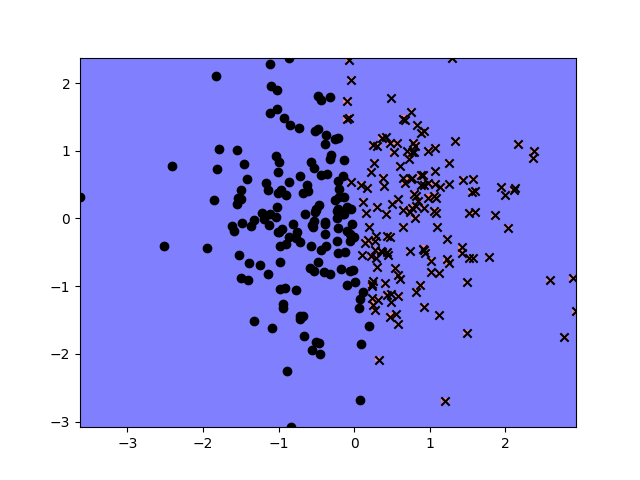

Training error: 0.0%


In [135]:
# xTr,yTr,xTe,yTe=spiraldata(300)
xTr, yTr = genrandomdata(300)
fun=autosvm(xTr,yTr)
visclassifier.visclassifier(fun,xTr,yTr)
err=torch.mean(((torch.sign(fun(xTr)))!=yTr).float())
print("Training error: %2.1f%%" % (err*100))

In [ ]:
# Hidden Test 11: competition
# ---------------------------
# This tests the error rate of your classifier on the competition datasets 
# (remember each cell in this notebook should run in < 5 minutes!)

In [ ]:
# Prints out the summary of tests passed/failed.